# **Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs**

## Problem Tasks: 
- Examine the **_Opal usage data_** from **Transport NSW** and assess the patterns of different transport modes including bus, rail and ferry. 

- Apply **clustering techniques** to potentially identify the **_seasonality_** of card usage.

We use the dataset taken from the [OpenData of Transport NSW](https://opendata.transport.nsw.gov.au/dataset/opal-trips-all-modes) which recorded the monthly transport uses from July 2016 to July 2021. The transport modes included in the dataset that we will analyse are train, bus, ferry, light rail, and metro. The dataset is in the `xlsx` format, and the file name of it is `transportmodecount`. We will use this dataset to identify some common pattern between the recorded months, and also cluster these months to see if there is any high transport-use volume months.

📊 **Process:**

- Cleaning and summarizing data (handling null values, getting basic statistics).

- Exploring transport trends (increase/decrease in usage over time).

- Applying clustering techniques to identify seasonal patterns or high-usage months.

🎯 **Goal:**

- To explore if there is any specific month that citizens use transport frequently; this then could be use to improve the transport service such as adding more trips on the high-demand months, or could be used to analyse the factors or reasons why the uses of service decreased on a certain period.

# Import Libraries

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Import Data

In [4]:
# Load data from the excel file
df = pd.read_excel("data/transportmodecount.xlsx", index_col=0, engine="openpyxl")

# Unpivot the DataFrame
df = df.T

# Remove the last row "Grand Total"
df = df.drop("Grand Total", axis=0)

# Remove time from the index
df.index = pd.to_datetime(df.index).date

# Preview the DataFrame
df.head()

Transport Modes,Bus,Ferry,Light rail,Metro,Train,Grand Total
2016-07-01,21198509.0,1213712.0,827732.0,NaN,28819249.0,52059202.0
2016-08-01,25210772.0,1095055.0,840800.0,NaN,32393980.0,59540607.0
2016-09-01,23011540.0,1143718.0,758073.0,NaN,30648352.0,55561683.0
2016-10-01,23095302.0,1281152.0,776960.0,NaN,30106833.0,55260247.0
2016-11-01,24422383.0,1302501.0,705265.0,NaN,31318279.0,57748428.0


The dataset contains monthly transport usage counts for different modes (Bus, Ferry, Light Rail, Metro, Train) from July 2016 to July 2021. The first column represents the transport mode, while the subsequent columns represent usage counts for different months. The last column, "**Grand Total**", sums up the total usage per mode.

### Missing Values Check-up

In [5]:
# Check for missing values
df.isna().sum()

Transport\nModes
Bus             0
Ferry           0
Light rail      0
Metro          34
Train           0
Grand Total     0
dtype: int64

There are **34 null values** in the `Metro` field. 

As the **Metro service** in NSW was firt introduced in 2019, _there will not exist Metro usage data before 2019_ → we will replace `NaN` values with `0`.

In [6]:
# Fill missing values with 0
df['Metro'] = df['Metro'].fillna(0)

### Data Summary

In [7]:
# DataFrame dimension
df.shape

(61, 6)

In [8]:
# DataFrame columns
df.columns

Index(['Bus', 'Ferry', 'Light rail', 'Metro', 'Train', 'Grand Total'], dtype='object', name='Transport\nModes')

In [9]:
# Statistical summary of the DataFrame
df.describe()

Transport Modes,Bus,Ferry,Light rail,Metro,Train,Grand Total
count,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01
mean,2.115637e+07,1.062945e+06,9.882385e+05,5.808296e+05,2.755950e+07,5.134788e+07
std,5.740788e+06,4.100610e+05,4.227730e+05,7.629534e+05,8.269252e+06,1.415594e+07
min,5.094308e+06,8.083200e+04,1.937200e+05,0.000000e+00,5.266764e+06,1.108138e+07
25%,1.703207e+07,6.772650e+05,8.152370e+05,0.000000e+00,2.103861e+07,4.195683e+07
50%,2.306499e+07,1.179849e+06,8.587270e+05,0.000000e+00,3.027515e+07,5.624810e+07
75%,2.532301e+07,1.302501e+06,9.986650e+05,1.162246e+06,3.345712e+07,6.048659e+07
max,2.874222e+07,1.738083e+06,2.180906e+06,2.206777e+06,3.756212e+07,6.844949e+07


**Key Insights:**

- **Train & Bus are the most used services**, with Train having the highest mean (~27.56M) and variability.

- **Metro has a minimum usage of 0**, indicating periods of inactivity.

- **Train and Bus have the highest fluctuations**, while Ferry and Light Rail show more stable usage.

- **Peak Train usage reaches ~37.56M**, the highest among all modes.

- **Median values align closely with the means**, suggesting a relatively normal distribution.

## Data Exploration

### Plot travelling trend of each Transport mode

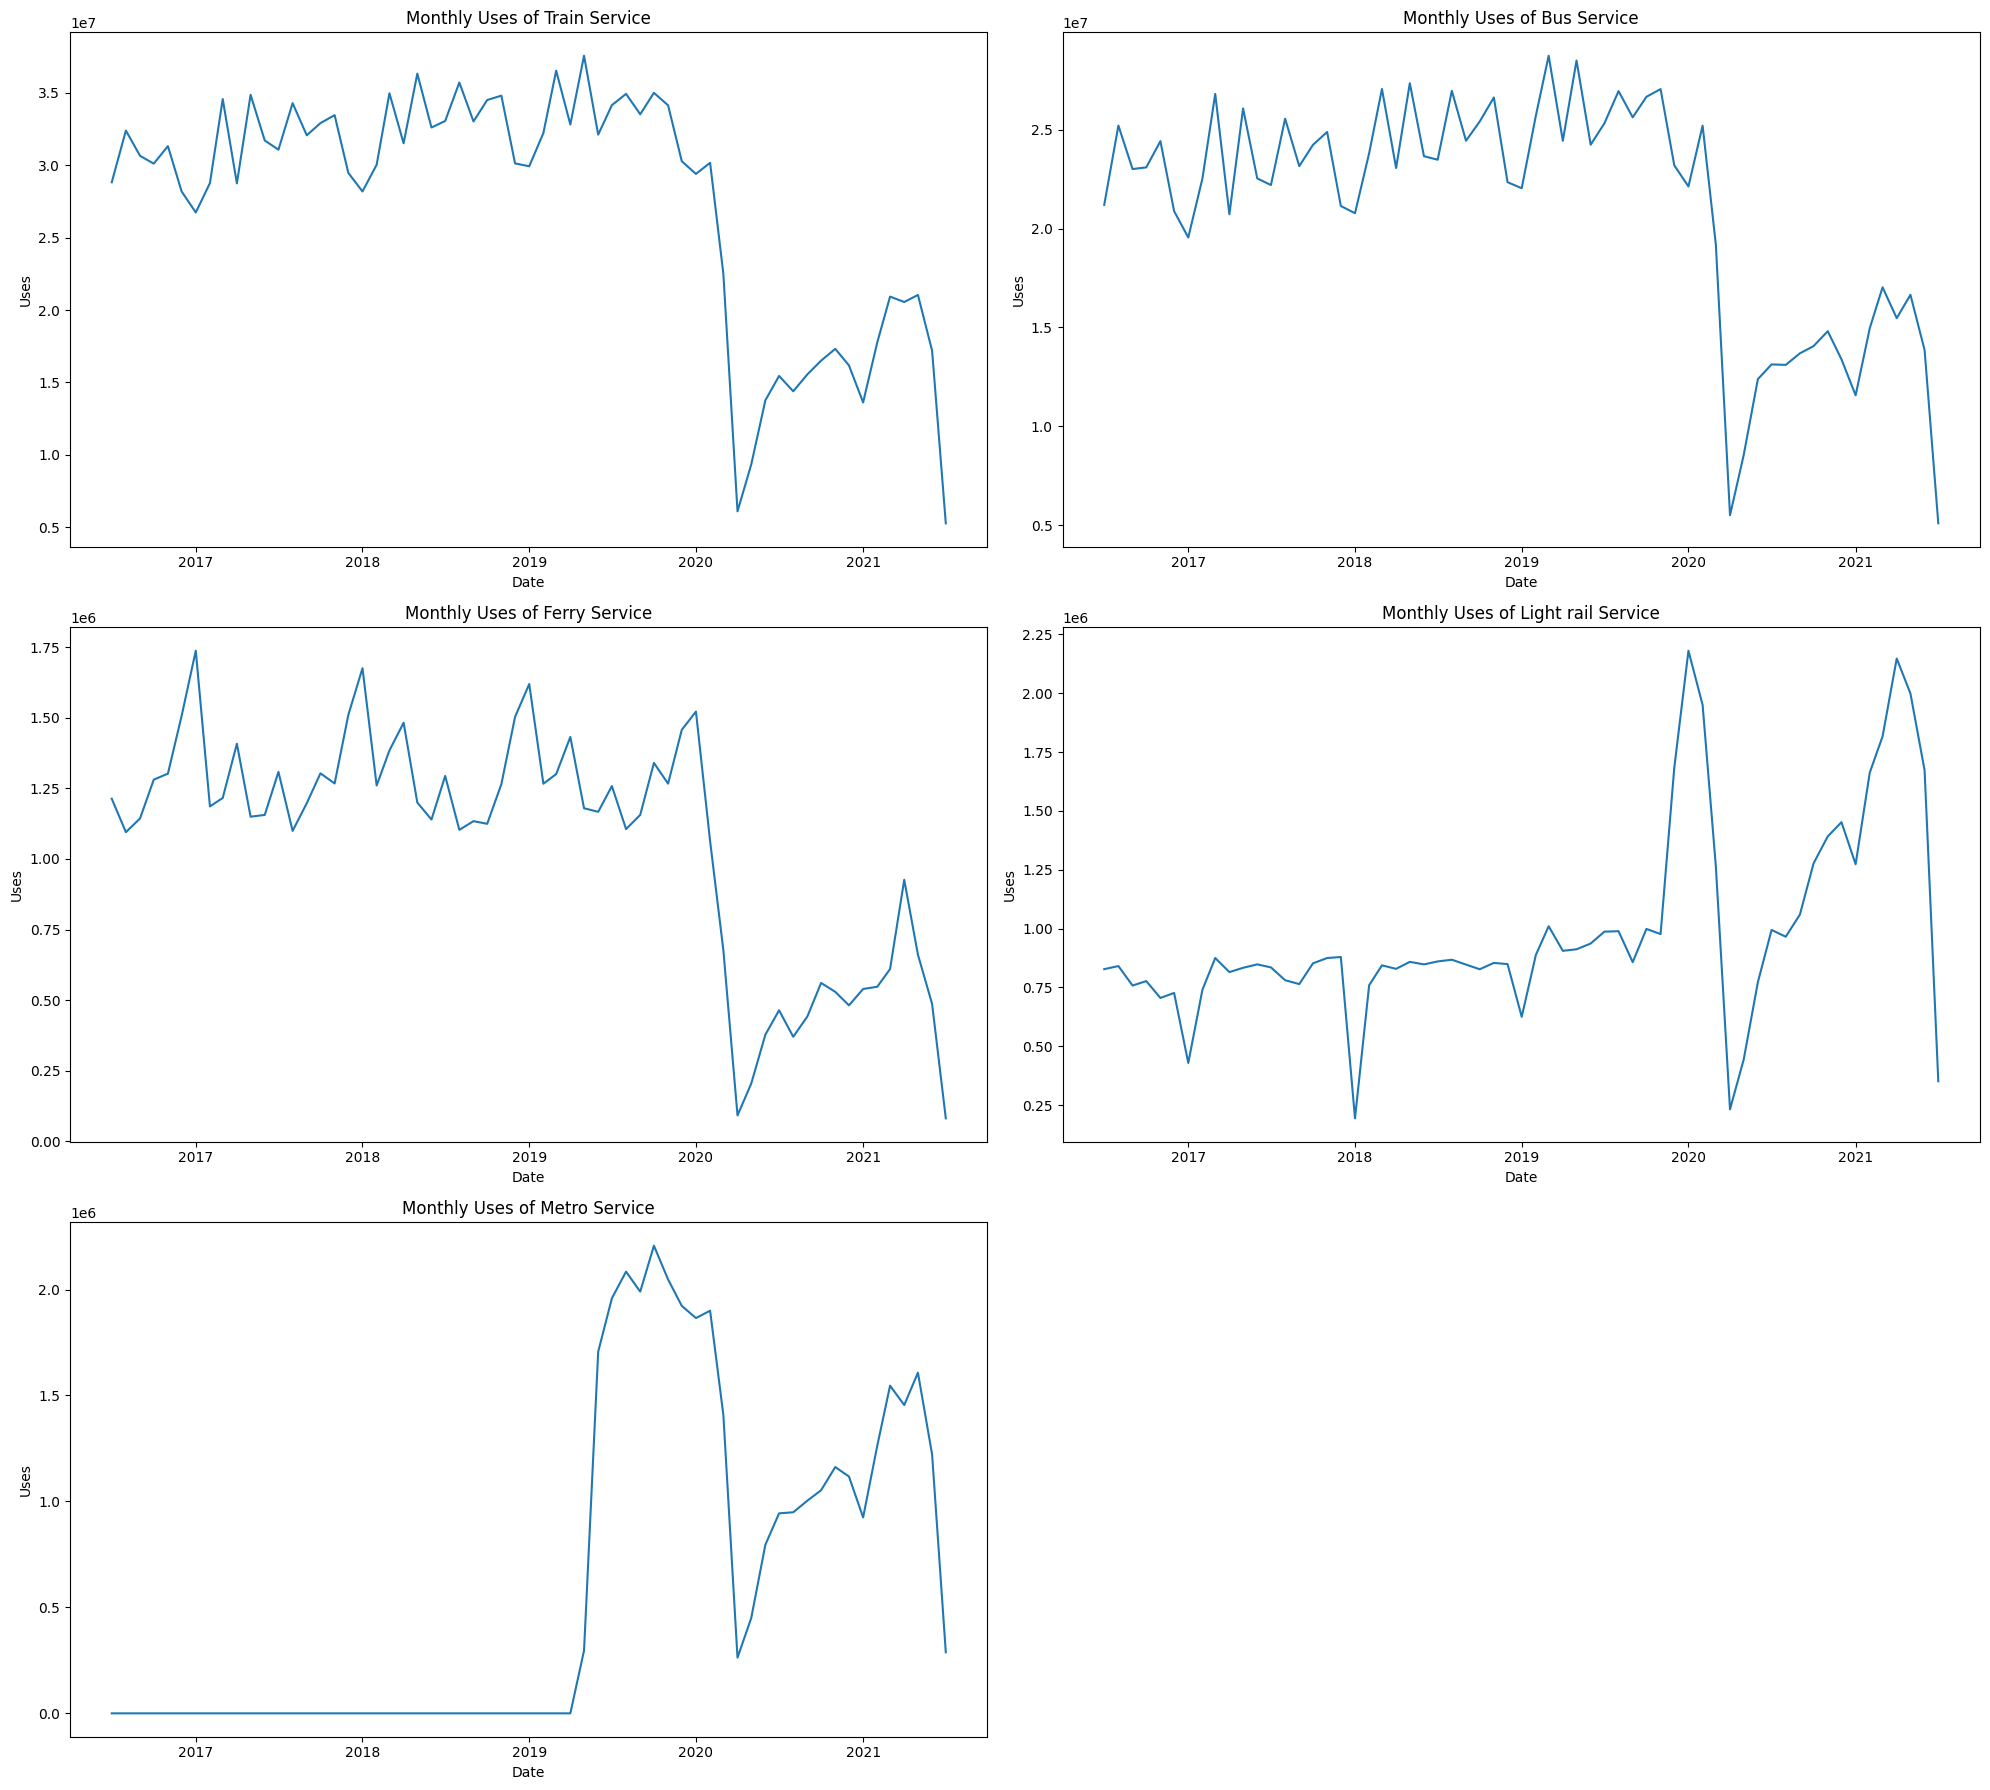

In [10]:
# Define all transport modes 
services = ["Train", "Bus", "Ferry", "Light rail", "Metro"]

# Set the figure size
plt.figure(figsize=(20, 18))

# Plot the time series for each transport mode
for i, service in enumerate(services, 1):
    plt.subplot(3, 2, i)
    plt.title(f"Monthly Uses of {service} Service")
    plt.xlabel("Date")
    plt.ylabel("Uses")
    plt.plot(df[service])

plt.tight_layout()
plt.show()


**Key Insights:**

1. COVID-19 Impact (2020):
    - There is a _sharp drop in usage_ for **all services** around early 2020, likely **_due to the pandemic_**.

    - Some services, such as **Metro and Light Rail**, show _a significant rebound_ afterward.

2. General Trends: 
    - **Train and Bus** services appear to have _the highest usage_ overall.

    - **Metro** service shows _a period of zero usage before 2019_, indicating it might be **_a newer service_**.

    - **Light Rail** usage seems to have _sudden peaks_, which might indicate **_infrastructure expansion or special events_**.

### Clustering

**Hierarchical clustering** is an unsupervised learning method for clustering data points. The algorithm builds clusters by measuring the dissimilarities between data.

Here we will use hierarchical clustering to **group data points and visualize the clusters using _a dendrogram_**. This method can be used on any data to visualize and interpret the relationship between individual data points.

Hierarchical clustering requires deciding on **both a distance and linkage method**. We will use **_euclidean distance_** and the **_Ward linkage_** method, which attempts to _minimize the variance between clusters_.

In [11]:
# Drop "Grand Total" column
df = df.drop(columns=['Grand Total'])

# Check the DataFrame after dropping "Grand Total"  
df.head()

Transport Modes,Bus,Ferry,Light rail,Metro,Train
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0


In [12]:
# Pairwise distance between pairs of observations in df 
pd = pdist(df,'euclidean')

# Create a linkage matrix using the complete method
lm = linkage(pd, method='ward')

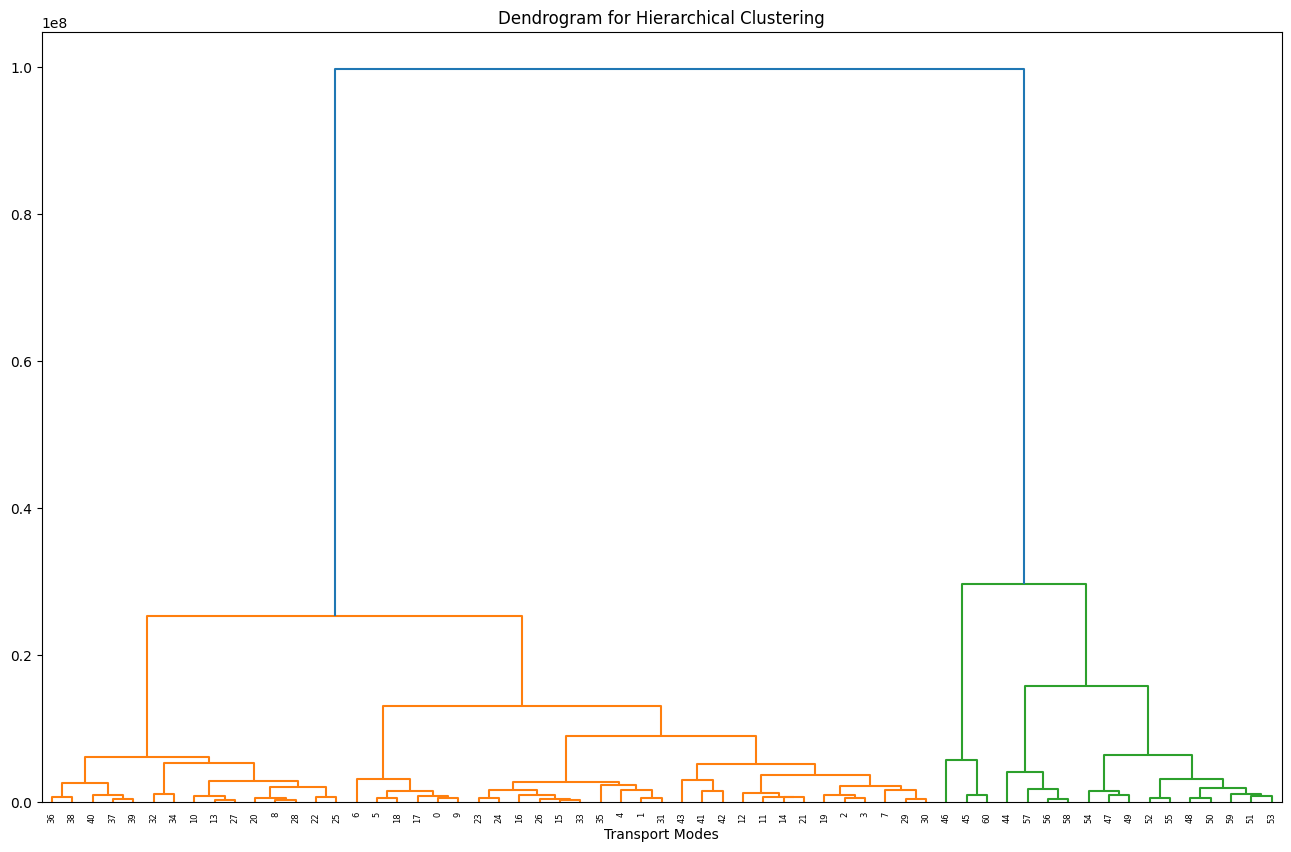

In [13]:
# Set the figure size for the dendrogram
plt.figure(figsize=(16,10))

# Dendrogram for hierarchical clustering
dendrogram(lm)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Transport Modes")   
plt.show()

In [14]:
# Retrieve the labels from the linkage matrix
labels = cut_tree(lm, n_clusters=3)

# Add the labels to the DataFrame
df['label'] = labels
df

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0,0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0,0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0,0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0,0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0,0
...,...,...,...,...,...,...
2021-03-01,17032074.0,609963.0,1816634.0,1546314.0,20925803.0,1
2021-04-01,15471111.0,926107.0,2147622.0,1454810.0,20552499.0,1
2021-05-01,16650452.0,660979.0,1999285.0,1607509.0,21038609.0,1
2021-06-01,13859329.0,486379.0,1672701.0,1222024.0,17193476.0,1


In [15]:
# Get the count of each label
df['label'].value_counts()

label
0    44
1    14
2     3
Name: count, dtype: int64

In [16]:
# Months labelled as Cluster 2
df[df['label']==2]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2020-04-01,5504822.0,91230.0,232032.0,262852.0,6095725.0,2
2020-05-01,8549735.0,203728.0,443833.0,449327.0,9323674.0,2
2021-07-01,5094308.0,80832.0,351308.0,288173.0,5266764.0,2


In [17]:
# Months labelled as Cluster 1
df[df['label']==1]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2020-03-01,19191569.0,677265.0,1264683.0,1408500.0,22506278.0,1
2020-06-01,12386023.0,377351.0,772279.0,795627.0,13762670.0,1
2020-07-01,13132371.0,463754.0,994370.0,943774.0,15446904.0,1
2020-08-01,13107189.0,369977.0,965468.0,948902.0,14385299.0,1
2020-09-01,13690626.0,441991.0,1059605.0,1003812.0,15556289.0,1
2020-10-01,14059038.0,560732.0,1277545.0,1052802.0,16502457.0,1
2020-11-01,14809745.0,529113.0,1391815.0,1162246.0,17317270.0,1
2020-12-01,13391873.0,481290.0,1452246.0,1117564.0,16173796.0,1
2021-01-01,11567325.0,539271.0,1273629.0,924685.0,13616536.0,1
2021-02-01,14964876.0,547260.0,1663207.0,1263058.0,17765453.0,1


In [18]:
# Months labelled as Cluster 0
df[df['label']==0]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0,0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0,0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0,0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0,0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0,0
2016-12-01,20880865.0,1506986.0,726521.0,0.0,28189584.0,0
2017-01-01,19550895.0,1738083.0,428998.0,0.0,26735422.0,0
2017-02-01,22534683.0,1186315.0,740308.0,0.0,28767036.0,0
2017-03-01,26811115.0,1216242.0,875062.0,0.0,34566385.0,0
2017-04-01,20723045.0,1408468.0,815237.0,0.0,28745729.0,0


In [19]:
# Months with no metro usage (before Metro service's construction in NSW)
df[df['Metro']==0]

Transport Modes,Bus,Ferry,Light rail,Metro,Train,label
2016-07-01,21198509.0,1213712.0,827732.0,0.0,28819249.0,0
2016-08-01,25210772.0,1095055.0,840800.0,0.0,32393980.0,0
2016-09-01,23011540.0,1143718.0,758073.0,0.0,30648352.0,0
2016-10-01,23095302.0,1281152.0,776960.0,0.0,30106833.0,0
2016-11-01,24422383.0,1302501.0,705265.0,0.0,31318279.0,0
2016-12-01,20880865.0,1506986.0,726521.0,0.0,28189584.0,0
2017-01-01,19550895.0,1738083.0,428998.0,0.0,26735422.0,0
2017-02-01,22534683.0,1186315.0,740308.0,0.0,28767036.0,0
2017-03-01,26811115.0,1216242.0,875062.0,0.0,34566385.0,0
2017-04-01,20723045.0,1408468.0,815237.0,0.0,28745729.0,0


### Cluster Exploration

In [ ]:
# Examine mean statistics of each cluster
df.groupby(['label']).agg('mean')

Transport Modes,Bus,Ferry,Light rail,Metro,Train
label,,,,,
0,2.427446e+07,1.290736e+06,8.978248e+05,4.086051e+05,3.222045e+07
1,1.452240e+07,5.479594e+05,1.410792e+06,1.175116e+06,1.733881e+07
2,6.382955e+06,1.252633e+05,3.423910e+05,3.334507e+05,6.895388e+06


**Key Insights:**

1. Distinct Clusters in Usage Patterns:

    - `Cluster 0` has the _highest average usage across all transport modes_, suggesting it represents **_high-demand periods or locations_**.

    - `Cluster 2` has the _lowest usage_, possibly indicating **_off-peak times or areas with less demand_**.

    - `Cluster 1` _sits in between_, with **_moderate usage_**.

2. **Metro & Light** Rail Differences:

    - Metro usage is _highest in Cluster 1_, which differs from other transport modes that peak in Cluster 0.

    - Light Rail usage is _significantly lower in Cluster 2_, meaning it is **_less utilized in certain conditions_**.

3. **Ferry Usage** Fluctuation:

    - The Ferry mode shows _less variation across clusters_, suggesting more **_consistent demand_** compared to Train or Bus services.

### Data Interpretation
From the hierarchical clustering of the data, we divided the data into 3 clusters, labeled [0,1,2], with 0 being approximately the cluster with the highest figures recorded - indicating months with the most frequent transport use, followed by 1 and finally 2 - the cluster with the lowest figures recorded, which indicates periods where people in NSW commute the least. 

There are 44 months labeled as cluster 0. Notably, all of these months were prior to 2021, with the vast majority being between 2016 and 2019 while only the first two months of 2020 are included of the cluster. 14 months are labeled as cluster 1, with 8 months in 2020 and the 6 first months of 2021. The 3 remaining months are part of cluster 2, the months with the least transport usage, which consists of April and May 2020 and July 2021. 

From the information collected and interpreted, we can see that public transport was considerably more popular in the earlier years of the study (2016 to 2019) - the lack of metro service did not affect the numbers, as we could see that all the months before the introduction of the metro service are in cluster 0, the cluster with the highest numbers. 

The drop in the public transport usage figures in the months in cluster 1, which consists of March 2020 and the period from June 2020 to June 2021, is likely due to the COVID-19 outbreak, where lockdown and social distancing laws are applied, limiting public transport use, and the pandemic may also affect people's decision to take public transport to an extent. This is also very likely the reason for the massive drop in the usage of public transport in the months in cluster 2, which are April and May 2020 as well as July 2021. Coincidentally, April 2020 was the month when Australia's borders were closed and lockdowns started. The lack of commuting to airports as well as the tighter applications of stay-at-home orders definitely contributed to the drop in transportation numbers. June 2020 was when the lockdown was lifted, therefore figures began to steadily rise up. July 2021 marked another lockdown in NSW, which accounts for the large drop in public transport usage.

## Clustering Reflection
With our original goal of finding specific months with frequent usage of public transport, the clustering method is not the most suitable for it, as many months were labeled as having high public transport usage. The relatively small sample size of 5 years, which means only 4-5 data points for each month, also prevents us from succeeding with our aim. What we could deduce from the data summary is that public transport usage was much higher between 2016 and 2019 than it is from 2020 onwards.

However, the clustering method did a decent job in finding specific months with low public transport usage, which could be reflected based on the real-life COVID-19 pandemic situation.